In [1]:
import os
os.chdir("..")

import time
import pandas as pd
import seaborn as sns
from src.baseline.evaluate import build_combined_single_frame, build_combined_dual_frame, best_single_treatment, best_dual_treatment
from src.baseline.evaluate import best_single_treatment_by_dosage, best_dual_treatment_by_dosage
from src.search.evaluate_search import best_multi_search_result
from src.env.cell_lines import retrieve_lines

%pylab inline
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['ptm', 'Helvetica', 'Times New Roman']

Populating the interactive namespace from numpy and matplotlib


In [2]:
LAMBDA_EXPONENTS = np.arange(-7.0, -1.0 + 0.01, 0.25)
PATH_EVAL = "./artifacts/evaluation/multi/"
PATH_DATA = "./artifacts/multi/"
THRESHOLD = 8000
VERIFICATION = False

# TODO: receive from command line arguments
OBJECTIVE = "worst"
DOMAIN = "simplex"
TISSUE = "skin"

In [3]:
def get_data_search():
    lambdas, proliferations, objectives, concentrations, treatments = [], [], [], [], []
    for la in LAMBDA_EXPONENTS:
        prefix = OBJECTIVE + "_" + DOMAIN + "_" + str(la).replace(".", "_") + "_cma_es" # create prefix here and then give it to function
        lambd = 10 ** la
        
        treat, o_dos, o_pro, o_obj = best_multi_search_result(TISSUE, PATH_DATA, prefix, lambd=lambd, obj=OBJECTIVE, max_dosage=THRESHOLD, verification=VERIFICATION)
        lambdas.append(lambd)
        proliferations.append(o_pro)
        objectives.append(o_obj)
        concentrations.append(o_dos)
        treatments.append(treat)
        
        if len(proliferations) % 5 == 0:
            print("   ...%2d lambdas loaded..." % len(lambdas))
    return lambdas, proliferations, objectives, concentrations, treatments

def get_data_single(lambdas):
    comb_data = build_combined_single_frame(retrieve_lines(TISSUE))
    proliferations, objectives, concentrations = [], [], []
    for lambd in lambdas:
        treat, s_dos, s_pro, s_obj = best_single_treatment(retrieve_lines(TISSUE), lambd=lambd, obj=OBJECTIVE, max_dosage=THRESHOLD, verification=VERIFICATION, comb_data=comb_data)
        proliferations.append(s_pro)
        objectives.append(s_obj)
        concentrations.append(s_dos)
        
        if len(proliferations) % 5 == 0:
            print("   ...%2d out of %d lambdas loaded..." % (len(proliferations), len(lambdas)))
    return proliferations, objectives, concentrations
    
def get_data_dual(lambdas):
    comb_data = build_combined_dual_frame(retrieve_lines(TISSUE))
    proliferations, objectives, concentrations = [], [], []
    for lambd in lambdas:
        treat, d_dos, d_pro, d_obj = best_dual_treatment(retrieve_lines(TISSUE), lambd=lambd, obj=OBJECTIVE, max_dosage=THRESHOLD, verification=VERIFICATION, comb_data=comb_data)
        proliferations.append(d_pro)
        objectives.append(d_obj)
        concentrations.append(d_dos)
        
        if len(proliferations) % 5 == 0:
            print("   ...%2d out of %d lambdas loaded..." % (len(proliferations), len(lambdas)))
    return proliferations, objectives, concentrations

In [4]:
t0 = time.time()
print("*** Search results ***")
lambdas, search_prolifs, search_objectives, search_concentration, search_treatments = get_data_search()
print(">>> Total time: ", round(time.time() - t0, 2), " seconds <<<\n")
t0 = time.time()

print("*** Single drug results ***")
single_prolifs, single_objectives, single_concentration = get_data_single(lambdas)
print(">>> Total time: ", round(time.time() - t0, 2), " seconds <<<\n")
t0 = time.time()

print("*** Dual drug results ***")
dual_prolifs, dual_objectives, dual_concentration = get_data_dual(lambdas)
print(">>> Total time: ", round(time.time() - t0, 2), " seconds <<<\n")
t0 = time.time()

print("*** All single drug results ***")
best_drugs, single_all_concentrations, single_all_prolifs = best_single_treatment_by_dosage(retrieve_lines(TISSUE), obj=OBJECTIVE, path="./artifacts/baselines/")
print(">>> Total time: ", round(time.time() - t0, 2), " seconds <<<\n")
t0 = time.time()

print("*** All dual drug results ***")
best_ratios, dual_all_concentrations, dual_all_prolifs = best_dual_treatment_by_dosage(retrieve_lines(TISSUE), obj=OBJECTIVE, path="./artifacts/baselines/")
print(">>> Total time: ", round(time.time() - t0, 2), " seconds <<<\n")


*** Search results ***
   ... 5 lambdas loaded...
   ...10 lambdas loaded...
   ...15 lambdas loaded...
   ...20 lambdas loaded...
   ...25 lambdas loaded...
>>> Total time:  0.5  seconds <<<

*** Single drug results ***
   ... 5 out of 25 lambdas loaded...
   ...10 out of 25 lambdas loaded...
   ...15 out of 25 lambdas loaded...
   ...20 out of 25 lambdas loaded...
   ...25 out of 25 lambdas loaded...
>>> Total time:  7.56  seconds <<<

*** Dual drug results ***
   ... 5 out of 25 lambdas loaded...
   ...10 out of 25 lambdas loaded...
   ...15 out of 25 lambdas loaded...
   ...20 out of 25 lambdas loaded...
   ...25 out of 25 lambdas loaded...
>>> Total time:  23.46  seconds <<<

*** All single drug results ***
>>> Total time:  8.0  seconds <<<

*** All dual drug results ***
>>> Total time:  25.02  seconds <<<



In [85]:
def drug_usage_plot(ax, search_treatments):
    cmap = matplotlib.cm.get_cmap("tab10")
    
    # create new dataframe from combined dictionary
    drug_usages = {} # drug name -> [drug dosage for lambda in LAMBDA_EXPONENTS]

    for i, _ in enumerate(LAMBDA_EXPONENTS):
        for k in search_treatments[i]:
            if k not in drug_usages:
                drug_usages[k] = []
            drug_usages[k].append(search_treatments[i][k])
    
    xs = [10**x for x in LAMBDA_EXPONENTS]
    w = 0.18 # Perceived width of each bar
    
    # Computes the widths of each bar. Since the axis is in log mode and we want all bars to have
    # the same "perceived" width, we need to solve the following equation:
    #
    # perceived_width = log(x + w(x) / 2) - log(x - w(x) / 2).
    #
    # This leads to the choice of widths below:
    widths = [2 * x * (10 ** w - 1) / (10 ** w + 1) for x in xs]
    
    # We stack the plots on top of each other.
    bots = {}
    bots["PD0325901"]   = np.zeros(len(LAMBDA_EXPONENTS))
    bots["PLX-4720"]    = np.array(drug_usages["PD0325901"])   + bots["PD0325901"]
    bots["Selumetinib"] = np.array(drug_usages["PLX-4720"])    + bots["PLX-4720"]
    bots["Lapatinib"]   = np.array(drug_usages["Selumetinib"]) + bots["Selumetinib"]
    bots["Erlotinib"]   = np.array(drug_usages["Lapatinib"])   + bots["Lapatinib"]
    bots["CHIR-265"]    = np.array(drug_usages["Erlotinib"])   + bots["Erlotinib"]
    bots["Vandetanib"]  = np.array(drug_usages["CHIR-265"])    + bots["CHIR-265"]

    p1 = plt.bar(xs, drug_usages["PD0325901"],   width=widths,                             edgecolor='white', color=cmap(0.2))
    p2 = plt.bar(xs, drug_usages["PLX-4720"],    width=widths, bottom=bots["PLX-4720"],    edgecolor='white', color=cmap(0.5))
    p3 = plt.bar(xs, drug_usages["Selumetinib"], width=widths, bottom=bots["Selumetinib"], edgecolor='white', color=cmap(0.4))
    p4 = plt.bar(xs, drug_usages["Lapatinib"],   width=widths, bottom=bots["Lapatinib"],   edgecolor='white', color=cmap(0.6))
    p5 = plt.bar(xs, drug_usages["Erlotinib"],   width=widths, bottom=bots["Erlotinib"],   edgecolor='white', color=cmap(0.3))
    p6 = plt.bar(xs, drug_usages["CHIR-265"],    width=widths, bottom=bots["CHIR-265"],    edgecolor='white', color=cmap(0.1))
    p7 = plt.bar(xs, drug_usages["Vandetanib"],  width=widths, bottom=bots["Vandetanib"],  edgecolor='white', color=cmap(0.0))

    ax.set_ylabel("Total dosage (nM)")
    ax.set_yticks([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])
    
    ax.set_axisbelow(True)
    ax.yaxis.grid(linestyle=(0, (5, 10)))
    
    ax.set_xlabel("Penalty ($\\lambda$)")
    ax.set_xscale('log')
    
    plt.legend((p7[0], p6[0], p5[0], p4[0], p3[0], p2[0], p1[0]), \
         ('Vandetanib', 'CHIR-265', "Erlotinib", "Lapatinib", "Selumetinib", "PLX-4720", "PD0325901"))

In [29]:
def prolif_vs_lambda_plot(ax, search_prolifs, single_prolifs, dual_prolifs):
    lambdas = [10**x for x in LAMBDA_EXPONENTS]
    
    ax.plot(lambdas, search_prolifs, label="Optimization Result")
    ax.plot(lambdas, single_prolifs, label="Best Single Drug")
    ax.plot(lambdas, dual_prolifs,   label="PD0325901 + PLX-4720")
    
    ax.set_xscale('log')
    ax.set_xlabel("Penalty ($\\lambda$)")
    ax.set_ylabel("Maximum relative proliferation")
    ax.legend()
    ax.grid()

In [30]:
def prolif_vs_dosage_plot(ax,
                          search_concentration, single_all_concentrations, dual_all_concentrations,
                          search_prolifs, single_all_prolifs, dual_all_prolifs):
    ax.plot(search_concentration,      search_prolifs,     label="Optimization Result")
    ax.plot(single_all_concentrations, single_all_prolifs, label="Best Single Drug")
    ax.plot(dual_all_concentrations,   dual_all_prolifs,   label="PD0325901 + PLX-4720")
    
    ax.set_xlabel("Total dosage (nM)")
    ax.set_ylabel("Maximum relative proliferation")
    ax.set_xticks([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])
    ax.legend()
    ax.grid()

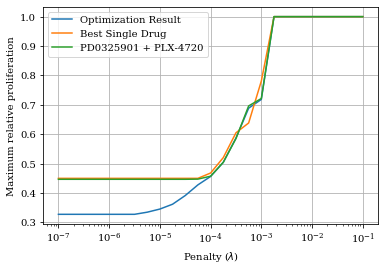

In [31]:
fig, ax = plt.subplots(figsize=(6,4))
prolif_vs_lambda_plot(ax, search_prolifs, single_prolifs, dual_prolifs)
fig.savefig(f"./notebooks/plots/multi_{TISSUE}_prolif_vs_lambda.pdf", bbox_inches='tight')

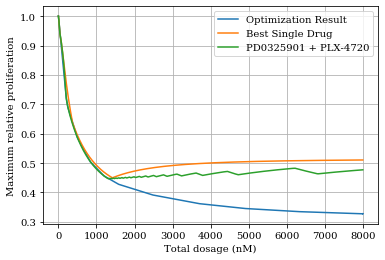

In [35]:
fig, ax = plt.subplots(figsize=(6,4))
prolif_vs_dosage_plot(ax, search_concentration, single_all_concentrations, dual_all_concentrations,
                          search_prolifs, single_all_prolifs, dual_all_prolifs)
fig.savefig(f"./notebooks/plots/multi_{TISSUE}_prolif_vs_dosage.pdf", bbox_inches='tight')

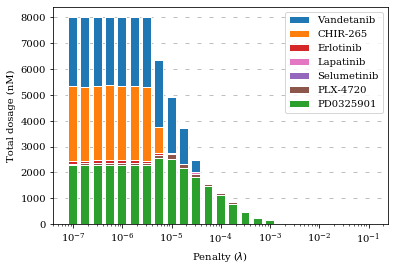

In [86]:
fig, ax = plt.subplots(figsize=(6,4))
drug_usage_plot(ax, search_treatments)
fig.savefig(f"./notebooks/plots/multi_{TISSUE}_search_dosage.pdf", bbox_inches='tight')